# Amazon Fine Food Review - Part 2

We did somw heavy computation to compute the sentiment scores for the amazon fine food reviews data. We will read the result csv and make use of that in further processing.

In [5]:
# Standard data manipulation libraries

import numpy as np
import pandas as pd

from pandas import Series, DataFrame

In [6]:
# Data visualization imports

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns

%matplotlib inline

In [7]:
# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split

# For evaluating our ML results
from sklearn import metrics

# Dataset Import
import statsmodels.api as sm

## Read in the original data set

We use the dtype argument to cast the Summary column to str to try to get rid of inconsistent data types due to
null/empty values

In [8]:
original_data = pd.read_csv('data/Reviews.csv', dtype = {'Summary': str})

In [9]:
original_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
original_data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


## Cleaning

The summary column contains nan values that are of types float. We need to replace the nans with empty strings

In [11]:
original_data.Summary = original_data.Summary.replace(np.nan, '')
original_data.Summary.apply(type).unique()

array([<class 'str'>], dtype=object)

## Read in the computed sentiment data

In [12]:
sentiments = pd.read_csv('amazon_sentimetns.csv')

In [13]:
sentiments.head()

,summary_polarity,summary_subjectivity,text_polarity,text_subjectivity
0,0.7,0.60,0.450000,0.433333
1,0.0,0.00,-0.033333,0.762963
2,0.0,0.00,0.133571,0.448571
3,0.0,0.00,0.166667,0.533333
4,0.8,0.75,0.483333,0.637500


## Improving the prediction accuracy of the logistic classifier

Our previous model had an accuracy of ~67%
We will try to improve upon it iteratively.

### Avoiding Multi-Coliniearity

We have already observed that the features summary polarity and text polarity are highly correlated. This can be illustrated by the following plots. The plots below show the the average sentiment (For summary and for text) against the review score. It turns out that when highly correlated features are used in a prediction model, it ends up creating distortions. Read more about it here: [Multi-colinearity on Wikipedia](https://en.wikipedia.org/wiki/Multicollinearity)

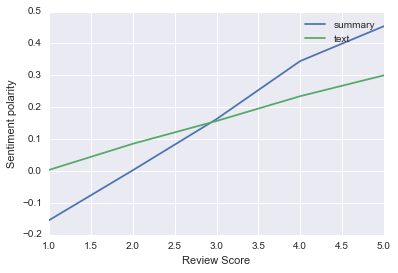

In [14]:
groupedByScore = sentiments.summary_polarity.groupby(original_data.Score)
plt.plot(groupedByScore.mean(), label='summary')
plt.plot((sentiments.text_polarity.groupby(original_data.Score)).mean(), label='text')
plt.xlabel('Review Score')
plt.ylabel('Sentiment polarity')
plt.legend()
plt.show()

In [15]:
Y = original_data.Score

In [16]:
X = DataFrame({'text_polarity': sentiments.text_polarity})

In [17]:
log_model = LogisticRegression()
# Split the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

# Make a new log_model
log_model = LogisticRegression()

# Now fit the new model
log_model.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [18]:
# Predict the classes of the testing data set
class_predict = log_model.predict(X_test)

# Compare the predicted classes to the actual test classes
print(metrics.accuracy_score(Y_test,class_predict))

0.650442602418


We can observe that by getting rid of three variables, our prediction accuracy detoriated by about 1%

Maybe the the extra features did not have much impact and although we haven't seen the erratic effects of multicollinearity in action, we still have managed to get rid of it with only a minimal accuracy impact.

## Exploring addtional featutures

To improve our accuracy further we can consider including some additonal features from our original dataset. 

Lets do another round of exploration.

In [19]:
original_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

### ProductID

Product ID could be a potentially useful factor for determining review scores because a good produc is more likely to have good reviews and vice versa. 

In [20]:
len(original_data.ProductId.unique())

74258

In [21]:
groupedByProductID = original_data.Score.groupby(original_data.ProductId)
np.std(groupedByProductID.mean())

1.0701744558634894

We grouped the review scores by the product ID and computed the mean for each of the groups. Further we calculated the standard deviation of the mean values across the groups. The idea being that the higher standard deviation would inidicate a high degree of variability due to the product ID which would potentially make it a good feature for prediction.

Since the product ID is a categorical variable, we can't use it as it is. We need to map to numerical data. Ideally we wouls one hot 

In [36]:
productID_means = groupedByProductID.mean()
mapped_product_id = original_data.ProductId.map(lambda x : productID_means[x])

In [54]:
X = DataFrame({'text_polarity': sentiments.text_polarity, 'productID': mapped_product_id})
X.head()

,productID,text_polarity
0,5.00,0.450000
1,1.00,-0.033333
2,4.00,0.133571
3,2.00,0.166667
4,4.75,0.483333


In [55]:
def standard_logistic_regression(X, Y):
    """
    takes the feature vectors and the output vector and performs a logistic regression.
    returns a tuple of the form (model, accuracy)
    """
    log_model = LogisticRegression()
    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

    # Make a new log_model
    log_model = LogisticRegression()

    # Now fit the new model
    log_model.fit(X_train, Y_train)
    
    # Predict the classes of the testing data set
    class_predict = log_model.predict(X_test)

    return(log_model, metrics.accuracy_score(Y_test,class_predict))

Instead of having five possible target outcomes for scores, lets add a new target variable which has a binary value, 1 being a good score and 0 being a bad score.

In [56]:
binary_score = original_data.Score.map(lambda x: int(x >= 3))
log_result = standard_logistic_regression(X, binary_score)

In [57]:
log_result[1]

0.88549333633561789

Lets drop the sentiment scores from the feature set and see how the model fares.

In [52]:
productIDOnly = DataFrame({'productID': mapped_product_id})
log_result = standard_logistic_regression(productIDOnly, binary_score)

In [53]:
log_result[1]

0.87108237049129567

Interestingly, there's only a very minor drop in accuracy. This might indicate that the product is a major contributor the score. Let's see how sentiments alone fare

In [58]:
polarityOnly = DataFrame({'text_polarity': sentiments.text_polarity})
log_result = standard_logistic_regression(polarityOnly, binary_score)
log_result[1]

0.86722631127123295

Looks like both sentiment and product ID are significant indicators of whether the rating would be high. Let's explore the influence of the user ID. To that end we will need to replicate the procedure previously done for productID

In [59]:
len(original_data.UserId.unique())

74258

In [61]:
groupedByUserId = original_data.Score.groupby(original_data.UserId)
np.std(groupedByUserId.mean())

1.3132586491933957

The standard deviation seems to be large enough for this grouping to be of utility for us. Since the number of unique users is again too large, one-hot encoding could be a bad idea in this case as well.

In [62]:
UserID_means = groupedByUserId.mean()
mapped_user_id = original_data.UserId.map(lambda x : UserID_means[x])

In [63]:
userIDOnly = DataFrame({'userID': mapped_user_id})
log_result = standard_logistic_regression(userIDOnly, binary_score)
log_result[1]

0.95807591088844168

That's an enexpectedy high accuracy. One would expect the product to be stronger determinant than the user. Let's see how the combination of product and user work.

In [64]:
userIDproductID = DataFrame({'userID': mapped_user_id, 'productID': mapped_product_id})
log_result = standard_logistic_regression(userIDproductID, binary_score)
log_result[1]

0.95730892100707887